In [1]:
import os
os.chdir('../')

In [2]:
%matplotlib inline
#%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy
from decimal import Decimal
from typing import List, Tuple
from warnings import warn

from cycler import cycler
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import PCA
import scipy.stats as stats
import torch
from torch import nn
import torch.nn.functional as F
import seml
from ogb.nodeproppred import PygNodePropPredDataset

import tqdm
tqdm.tqdm.pandas()

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
from notebooks import mpl_latex

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [ ]:
mpl_latex.enable_production_mode()

In [5]:
from rgnn_at_scale.data import prep_graph, split
from rgnn_at_scale.attacks import create_attack, SPARSE_ATTACKS
from rgnn_at_scale.io import Storage
from rgnn_at_scale.models import DenseGCN, GCN
from rgnn_at_scale.train import train
from rgnn_at_scale.utils import accuracy

In [43]:
dataset = 'ogbn-arxiv'
binary_attr = False
attack = 'PRBCD'
seed = 0
device = 0
surrogate_params = {
    'n_filters': [256, 256],
    'dropout': 0.5,
    'with_batchnorm': True,
    'train_params': {
        'lr': 1e-2,
        'weight_decay': 0,
        'patience': 100,
        'max_epochs': 3000
    }
}
attack_params = {
    'keep_heuristic': 'WeightOnly'
}
search_space_sizes = [350_000, 600_000, 1_000_000, 10_000_000, 100_000_000]
epsilon = 0.25
display_steps = 10

torch.manual_seed(seed)
np.random.seed(seed)

In [44]:
data = prep_graph(dataset, device='cpu', binary_attr=binary_attr, return_original_split=dataset.startswith('ogbn'))
if len(data) == 3:
    attr, adj, labels = data
    idx_train, idx_val, idx_test = data.split(labels.cpu().numpy())
else:
    attr, adj, labels, split = data
    idx_train, idx_val, idx_test = split['train'], split['valid'], split['test']
n_features = attr.shape[1]
n_classes = int(labels.max() + 1)

In [45]:
gcn = GCN(n_classes=n_classes, n_features=n_features, **surrogate_params).to(device)
train(model=gcn, attr=attr.to(device), adj=adj.to(device), labels=labels.to(device),
      idx_train=idx_train, idx_val=idx_val, display_step=display_steps, **surrogate_params['train_params'])

([3.6812374591827393,
  3.299337387084961,
  3.130230188369751,
  3.088383674621582,
  3.1026856899261475,
  3.1268703937530518,
  3.103090286254883,
  2.9817304611206055,
  2.8416600227355957,
  2.7501606941223145,
  2.69582200050354,
  2.611743688583374,
  2.443920612335205,
  2.325803279876709,
  2.252542018890381,
  2.2287731170654297,
  2.1651172637939453,
  2.0694539546966553,
  1.9969720840454102,
  1.9508193731307983,
  1.9017360210418701,
  1.8424190282821655,
  1.803155779838562,
  1.7869112491607666,
  1.7375105619430542,
  1.706944227218628,
  1.6644595861434937,
  1.6422145366668701,
  1.6161003112792969,
  1.590244174003601,
  1.5692012310028076,
  1.5343133211135864,
  1.5045925378799438,
  1.4842228889465332,
  1.4742742776870728,
  1.4485832452774048,
  1.4336477518081665,
  1.4240714311599731,
  1.4116452932357788,
  1.3911151885986328,
  1.3750284910202026,
  1.3710912466049194,
  1.354235053062439,
  1.3420730829238892,
  1.3289378881454468,
  1.3218227624893188,
  

In [46]:
with torch.no_grad():
    pred_logits_surr = gcn(attr.to(device), adj.to(device))
accuracy(pred_logits_surr, labels.to(device), idx_test)

0.6971997618675232

In [47]:
results = []
for search_space_size in search_space_sizes:
    temp_attack_params = dict(attack_params)
    temp_attack_params['search_space_size'] = search_space_size
    adversary = create_attack(attack, adj=adj, X=attr, labels=labels,
                              model=gcn, idx_attack=idx_test, device=device, **temp_attack_params)

    m = adj._nnz() / 2
    torch.manual_seed(seed)
    np.random.seed(seed)

    n_perturbations = int(round(epsilon * m))
    adversary.attack(n_perturbations)
    
    results.append(adversary.attack_statistics)

  0%|          | 2/500 [00:00<01:02,  7.96it/s]


Epoch: 0 Loss: 0.9177029728889465 Accuracy: 71.191 %



  4%|▍         | 22/500 [00:02<00:59,  8.01it/s]


Epoch: 20 Loss: 2.8795361518859863 Accuracy: 41.483 %



  8%|▊         | 42/500 [00:05<00:57,  8.02it/s]


Epoch: 40 Loss: 3.120222568511963 Accuracy: 41.393 %



 12%|█▏        | 62/500 [00:07<00:54,  8.00it/s]


Epoch: 60 Loss: 3.2458040714263916 Accuracy: 41.353 %



 16%|█▋        | 82/500 [00:10<00:52,  7.99it/s]


Epoch: 80 Loss: 3.3256990909576416 Accuracy: 41.347 %



 20%|██        | 102/500 [00:12<00:49,  8.01it/s]


Epoch: 100 Loss: 3.383725643157959 Accuracy: 41.432 %



 24%|██▍       | 122/500 [00:15<00:47,  7.97it/s]


Epoch: 120 Loss: 3.427499294281006 Accuracy: 41.427 %



 28%|██▊       | 142/500 [00:17<00:44,  7.98it/s]


Epoch: 140 Loss: 3.4631614685058594 Accuracy: 41.436 %



 32%|███▏      | 162/500 [00:20<00:42,  8.00it/s]


Epoch: 160 Loss: 3.491077184677124 Accuracy: 41.467 %



 36%|███▋      | 182/500 [00:22<00:39,  7.99it/s]


Epoch: 180 Loss: 3.515307664871216 Accuracy: 41.458 %



 40%|████      | 202/500 [00:25<00:37,  8.00it/s]


Epoch: 200 Loss: 3.535660743713379 Accuracy: 41.481 %



 44%|████▍     | 222/500 [00:27<00:34,  7.97it/s]


Epoch: 220 Loss: 3.5535426139831543 Accuracy: 41.487 %



 48%|████▊     | 242/500 [00:30<00:32,  7.97it/s]


Epoch: 240 Loss: 3.568582534790039 Accuracy: 41.487 %



 52%|█████▏    | 262/500 [00:32<00:29,  8.02it/s]


Epoch: 260 Loss: 3.5825414657592773 Accuracy: 41.508 %



 56%|█████▋    | 282/500 [00:35<00:27,  7.97it/s]


Epoch: 280 Loss: 3.594339609146118 Accuracy: 41.504 %



 60%|██████    | 302/500 [00:37<00:24,  7.98it/s]


Epoch: 300 Loss: 3.605616569519043 Accuracy: 41.502 %



 64%|██████▍   | 322/500 [00:40<00:22,  7.98it/s]


Epoch: 320 Loss: 3.615779161453247 Accuracy: 41.508 %



 68%|██████▊   | 342/500 [00:42<00:19,  8.01it/s]


Epoch: 340 Loss: 3.6248137950897217 Accuracy: 41.528 %



 72%|███████▏  | 362/500 [00:45<00:17,  7.95it/s]


Epoch: 360 Loss: 3.633784532546997 Accuracy: 41.534 %



 76%|███████▋  | 382/500 [00:47<00:14,  7.99it/s]


Epoch: 380 Loss: 3.6417527198791504 Accuracy: 41.541 %



 80%|████████  | 401/500 [00:50<00:12,  8.05it/s]

Loading search space of epoch 399 (loss=3.648738145828247) for fine tuning


Epoch: 400 Loss: 3.648738145828247 Accuracy: 41.549 %



 84%|████████▍ | 422/500 [00:52<00:09,  8.22it/s]


Epoch: 420 Loss: 3.722411632537842 Accuracy: 40.689 %



 88%|████████▊ | 442/500 [00:55<00:07,  8.19it/s]


Epoch: 440 Loss: 3.729790687561035 Accuracy: 40.561 %



 92%|█████████▏| 462/500 [00:57<00:04,  8.15it/s]


Epoch: 460 Loss: 3.7329680919647217 Accuracy: 40.469 %



 96%|█████████▋| 482/500 [01:00<00:02,  8.18it/s]


Epoch: 480 Loss: 3.734814405441284 Accuracy: 40.450 %



  0%|          | 2/500 [00:00<01:08,  7.32it/s]


Epoch: 0 Loss: 0.9177029728889465 Accuracy: 71.191 %



  4%|▍         | 22/500 [00:03<01:05,  7.26it/s]


Epoch: 20 Loss: 3.6479711532592773 Accuracy: 36.027 %



  8%|▊         | 42/500 [00:05<01:02,  7.27it/s]


Epoch: 40 Loss: 4.071608066558838 Accuracy: 35.481 %



 12%|█▏        | 62/500 [00:08<01:00,  7.30it/s]


Epoch: 60 Loss: 4.280996322631836 Accuracy: 35.381 %



 16%|█▋        | 82/500 [00:11<00:57,  7.31it/s]


Epoch: 80 Loss: 4.413663387298584 Accuracy: 35.341 %



 20%|██        | 102/500 [00:13<00:54,  7.26it/s]


Epoch: 100 Loss: 4.505356788635254 Accuracy: 35.366 %



 24%|██▍       | 122/500 [00:16<00:51,  7.27it/s]


Epoch: 120 Loss: 4.57467794418335 Accuracy: 35.348 %



 28%|██▊       | 142/500 [00:19<00:49,  7.26it/s]


Epoch: 140 Loss: 4.628367900848389 Accuracy: 35.366 %



 32%|███▏      | 162/500 [00:22<00:46,  7.29it/s]


Epoch: 160 Loss: 4.6727495193481445 Accuracy: 35.383 %



 36%|███▋      | 182/500 [00:24<00:43,  7.27it/s]


Epoch: 180 Loss: 4.708847522735596 Accuracy: 35.426 %



 40%|████      | 202/500 [00:27<00:40,  7.30it/s]


Epoch: 200 Loss: 4.738522052764893 Accuracy: 35.440 %



 44%|████▍     | 222/500 [00:30<00:38,  7.29it/s]


Epoch: 220 Loss: 4.76427698135376 Accuracy: 35.453 %



 48%|████▊     | 242/500 [00:33<00:35,  7.27it/s]


Epoch: 240 Loss: 4.787085056304932 Accuracy: 35.459 %



 52%|█████▏    | 262/500 [00:35<00:32,  7.29it/s]


Epoch: 260 Loss: 4.806507587432861 Accuracy: 35.469 %



 56%|█████▋    | 282/500 [00:38<00:29,  7.28it/s]


Epoch: 280 Loss: 4.823272705078125 Accuracy: 35.461 %



 60%|██████    | 302/500 [00:41<00:27,  7.27it/s]


Epoch: 300 Loss: 4.8387603759765625 Accuracy: 35.473 %



 64%|██████▍   | 322/500 [00:44<00:24,  7.28it/s]


Epoch: 320 Loss: 4.853616714477539 Accuracy: 35.483 %



 68%|██████▊   | 342/500 [00:46<00:21,  7.29it/s]


Epoch: 340 Loss: 4.8658928871154785 Accuracy: 35.481 %



 72%|███████▏  | 362/500 [00:49<00:18,  7.31it/s]


Epoch: 360 Loss: 4.8772125244140625 Accuracy: 35.496 %



 76%|███████▋  | 382/500 [00:52<00:16,  7.27it/s]


Epoch: 380 Loss: 4.8878173828125 Accuracy: 35.510 %



 80%|████████  | 401/500 [00:54<00:13,  7.40it/s]

Loading search space of epoch 399 (loss=4.8973541259765625) for fine tuning


Epoch: 400 Loss: 4.8973541259765625 Accuracy: 35.529 %



 84%|████████▍ | 422/500 [00:57<00:10,  7.16it/s]


Epoch: 420 Loss: 4.95309591293335 Accuracy: 34.971 %



 88%|████████▊ | 442/500 [01:00<00:08,  7.06it/s]


Epoch: 440 Loss: 4.961227893829346 Accuracy: 34.916 %



 92%|█████████▏| 462/500 [01:03<00:05,  7.02it/s]


Epoch: 460 Loss: 4.966372489929199 Accuracy: 34.879 %



 96%|█████████▋| 482/500 [01:06<00:02,  7.03it/s]


Epoch: 480 Loss: 4.969686031341553 Accuracy: 34.854 %



  0%|          | 2/500 [00:00<01:17,  6.44it/s]


Epoch: 0 Loss: 0.9177029728889465 Accuracy: 71.191 %



  4%|▍         | 21/500 [00:03<01:19,  6.02it/s]


Epoch: 20 Loss: 4.1519551277160645 Accuracy: 32.002 %



  8%|▊         | 41/500 [00:06<01:16,  5.98it/s]


Epoch: 40 Loss: 4.911839485168457 Accuracy: 31.091 %



 12%|█▏        | 61/500 [00:10<01:13,  5.99it/s]


Epoch: 60 Loss: 5.33060884475708 Accuracy: 30.850 %



 16%|█▌        | 81/500 [00:13<01:09,  5.99it/s]


Epoch: 80 Loss: 5.608366966247559 Accuracy: 30.862 %



 20%|██        | 101/500 [00:16<01:06,  5.98it/s]


Epoch: 100 Loss: 5.81366491317749 Accuracy: 30.817 %



 24%|██▍       | 121/500 [00:20<01:03,  5.97it/s]


Epoch: 120 Loss: 5.975338935852051 Accuracy: 30.895 %



 28%|██▊       | 141/500 [00:23<00:59,  6.00it/s]


Epoch: 140 Loss: 6.108808994293213 Accuracy: 30.936 %



 32%|███▏      | 161/500 [00:26<00:56,  5.98it/s]


Epoch: 160 Loss: 6.222498893737793 Accuracy: 30.986 %



 36%|███▌      | 181/500 [00:30<00:53,  6.00it/s]


Epoch: 180 Loss: 6.321413516998291 Accuracy: 31.047 %



 40%|████      | 201/500 [00:33<00:49,  6.03it/s]


Epoch: 200 Loss: 6.410383701324463 Accuracy: 31.085 %



 44%|████▍     | 221/500 [00:36<00:46,  6.01it/s]


Epoch: 220 Loss: 6.490270614624023 Accuracy: 31.165 %



 48%|████▊     | 241/500 [00:40<00:43,  5.99it/s]


Epoch: 240 Loss: 6.561935901641846 Accuracy: 31.218 %



 52%|█████▏    | 261/500 [00:43<00:39,  6.01it/s]


Epoch: 260 Loss: 6.628504753112793 Accuracy: 31.280 %



 56%|█████▌    | 281/500 [00:46<00:36,  6.02it/s]


Epoch: 280 Loss: 6.6902313232421875 Accuracy: 31.321 %



 60%|██████    | 301/500 [00:50<00:33,  6.02it/s]


Epoch: 300 Loss: 6.747853755950928 Accuracy: 31.331 %



 64%|██████▍   | 321/500 [00:53<00:29,  6.00it/s]


Epoch: 320 Loss: 6.802462100982666 Accuracy: 31.358 %



 68%|██████▊   | 341/500 [00:56<00:26,  6.00it/s]


Epoch: 340 Loss: 6.853848457336426 Accuracy: 31.428 %



 72%|███████▏  | 361/500 [01:00<00:23,  6.00it/s]


Epoch: 360 Loss: 6.902551174163818 Accuracy: 31.471 %



 76%|███████▌  | 381/500 [01:03<00:19,  6.01it/s]


Epoch: 380 Loss: 6.947659015655518 Accuracy: 31.521 %



 80%|████████  | 401/500 [01:06<00:16,  6.09it/s]

Loading search space of epoch 399 (loss=6.9879279136657715) for fine tuning


Epoch: 400 Loss: 6.9879279136657715 Accuracy: 31.554 %



 84%|████████▍ | 422/500 [01:10<00:12,  6.16it/s]


Epoch: 420 Loss: 7.1234660148620605 Accuracy: 31.809 %



 88%|████████▊ | 442/500 [01:13<00:09,  6.18it/s]


Epoch: 440 Loss: 7.146644115447998 Accuracy: 31.868 %



 92%|█████████▏| 462/500 [01:16<00:06,  6.20it/s]


Epoch: 460 Loss: 7.158300399780273 Accuracy: 31.870 %



 96%|█████████▋| 482/500 [01:19<00:02,  6.18it/s]


Epoch: 480 Loss: 7.165645122528076 Accuracy: 31.887 %



  0%|          | 0/500 [00:00<?, ?it/s]


Epoch: 0 Loss: 0.9177029132843018 Accuracy: 71.191 %



  4%|▍         | 20/500 [00:14<05:53,  1.36it/s]


Epoch: 20 Loss: 6.234558582305908 Accuracy: 35.578 %



  8%|▊         | 40/500 [00:29<05:39,  1.35it/s]


Epoch: 40 Loss: 6.998620986938477 Accuracy: 35.286 %



 12%|█▏        | 60/500 [00:44<05:27,  1.34it/s]


Epoch: 60 Loss: 7.407101154327393 Accuracy: 35.385 %



 16%|█▌        | 80/500 [00:59<05:10,  1.35it/s]


Epoch: 80 Loss: 7.680302143096924 Accuracy: 35.463 %



 20%|██        | 100/500 [01:14<04:57,  1.34it/s]


Epoch: 100 Loss: 7.882480144500732 Accuracy: 35.605 %



 24%|██▍       | 120/500 [01:29<04:41,  1.35it/s]


Epoch: 120 Loss: 8.043246269226074 Accuracy: 35.724 %



 28%|██▊       | 140/500 [01:43<04:28,  1.34it/s]


Epoch: 140 Loss: 8.175474166870117 Accuracy: 35.796 %



 32%|███▏      | 160/500 [01:58<04:13,  1.34it/s]


Epoch: 160 Loss: 8.286859512329102 Accuracy: 35.866 %



 36%|███▌      | 180/500 [02:13<03:58,  1.34it/s]


Epoch: 180 Loss: 8.382651329040527 Accuracy: 35.887 %



 40%|████      | 200/500 [02:28<03:41,  1.35it/s]


Epoch: 200 Loss: 8.465330123901367 Accuracy: 35.959 %



 44%|████▍     | 220/500 [02:43<03:29,  1.34it/s]


Epoch: 220 Loss: 8.537125587463379 Accuracy: 36.014 %



 48%|████▊     | 240/500 [02:58<03:15,  1.33it/s]


Epoch: 240 Loss: 8.596914291381836 Accuracy: 36.043 %



 52%|█████▏    | 260/500 [03:13<02:58,  1.35it/s]


Epoch: 260 Loss: 8.644290924072266 Accuracy: 36.078 %



 56%|█████▌    | 280/500 [03:28<02:45,  1.33it/s]


Epoch: 280 Loss: 8.679136276245117 Accuracy: 36.092 %



 60%|██████    | 300/500 [03:43<02:29,  1.34it/s]


Epoch: 300 Loss: 8.70173454284668 Accuracy: 36.103 %



 64%|██████▍   | 320/500 [03:58<02:13,  1.34it/s]


Epoch: 320 Loss: 8.715965270996094 Accuracy: 36.097 %



 68%|██████▊   | 340/500 [04:13<02:00,  1.33it/s]


Epoch: 340 Loss: 8.72620677947998 Accuracy: 36.113 %



 72%|███████▏  | 360/500 [04:27<01:40,  1.40it/s]


Epoch: 360 Loss: 8.734015464782715 Accuracy: 36.115 %



 76%|███████▌  | 381/500 [04:42<01:24,  1.42it/s]


Epoch: 380 Loss: 8.740354537963867 Accuracy: 36.125 %



 80%|████████  | 400/500 [04:57<01:14,  1.34it/s]

Loading search space of epoch 399 (loss=8.746184349060059) for fine tuning



 80%|████████  | 401/500 [04:57<01:09,  1.42it/s]


Epoch: 400 Loss: 8.746184349060059 Accuracy: 36.134 %



 84%|████████▍ | 420/500 [05:11<00:56,  1.41it/s]


Epoch: 420 Loss: 8.871386528015137 Accuracy: 36.257 %



 88%|████████▊ | 440/500 [05:25<00:42,  1.41it/s]


Epoch: 440 Loss: 8.892763137817383 Accuracy: 36.269 %



 92%|█████████▏| 460/500 [05:39<00:28,  1.42it/s]


Epoch: 460 Loss: 8.903620719909668 Accuracy: 36.276 %



 96%|█████████▌| 480/500 [05:53<00:14,  1.42it/s]


Epoch: 480 Loss: 8.910557746887207 Accuracy: 36.280 %



  0%|          | 0/500 [00:02<?, ?it/s]


RuntimeError: transform: failed to synchronize: cudaErrorIllegalAddress: an illegal memory access was encountered

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


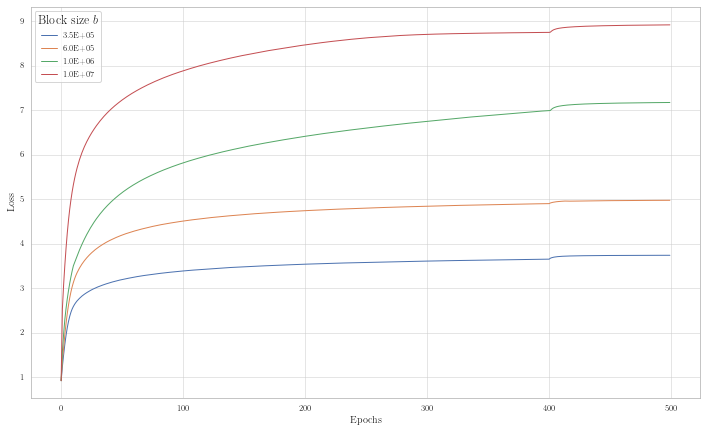

In [48]:
fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=0.6)
for result, search_space_size in zip(results, search_space_sizes[:-1]):
    plt.plot(result['loss'], label=f'{search_space_size:.1E}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(title='Block size $b$')

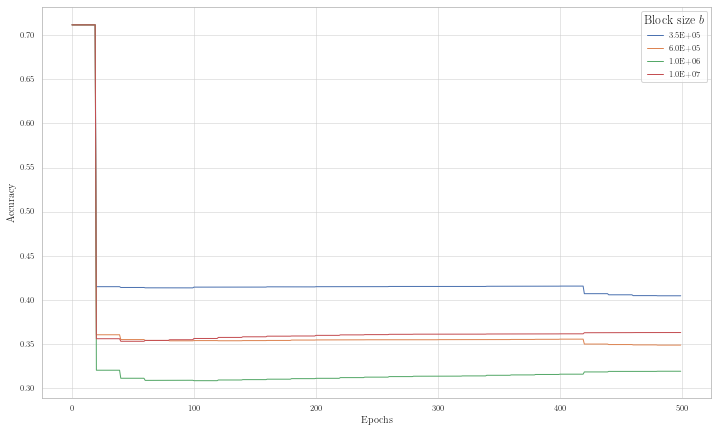

In [50]:
fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=0.6)
for result, search_space_size in zip(results, search_space_sizes):
    plt.plot(result['accuracy'], label=f'{search_space_size:.1E}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(title='Block size $b$')

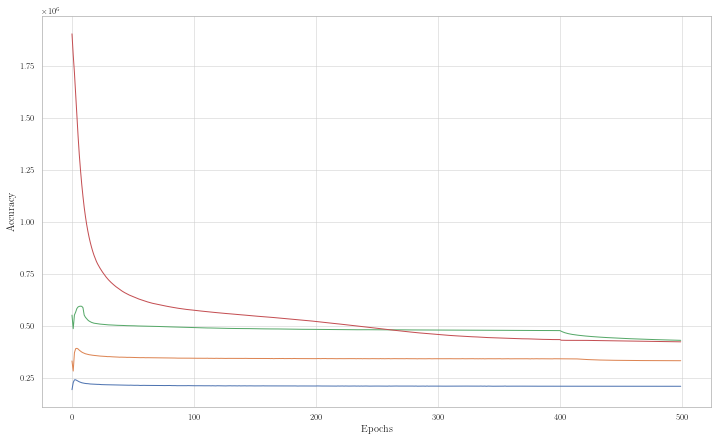

In [54]:
fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=0.6)
for result, search_space_size in zip(results, search_space_sizes):
    plt.plot(result['nonzero_weights'], label=search_space_size)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

In [53]:
list(results[0].keys())

['loss', 'accuracy', 'nonzero_weights', 'expected_perturbations']